Для сведения к бинарной классификации можно разбить на два класса: Никогда не использовавшиеся и использовавшиеся более десяти лет назад помещаются в класс, а все остальные в другую.





In [69]:
# импортируем нужные нам библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier 
from sklearn.pipeline import Pipeline

from model import model_grid, forest_importances
from graphs import plot_confusion_matrix

In [30]:
df = pd.read_csv('../data/data_preprocessed.csv')

In [31]:
df.tail()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
1880,18-24,0,Left schl at 17,USA,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,18-24,1,Left schl at 17,USA,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,25-34,0,univ degree,USA,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,18-24,0,Left schl at 17,USA,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1884,18-24,1,Left schl at 17,IRE,White,-0.46725,2.12700,1.65653,1.11406,0.41594,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


# **Binary Classification**

## Preprocessing data for binary classification

In [32]:
# Заменяем наши классы вещественными значениями от -3.0 до 3.0
# Для дальнейшего создания целевой бинарной переменной
df.replace(['CL0','CL1','CL2','CL3','CL4','CL5','CL6'],[-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0], inplace=True)

In [33]:
# Создаем новый dataframe для тестовой части
feature_names = ['Age','Gender','Educ','Cntry','Ethn','NS','ES','OS','AS','CS','SS','Alcohol','Caffeine','Choco','Nicotine']
df_bite = pd.DataFrame.copy(df[feature_names])

In [34]:
# Список наркотиков.
drug_names = ['Amphet','Amyl','Benzos','Cannabis','Coke','Crack','Ecstasy','Heroin','Ketamine',
                           'LegalH','LSD','Meth','Shrooms','Semer','VSA']
# Создаем таргет с нулевыми значениями
df_bite['target'] = int(0)

In [35]:
df_bite.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,SS,Alcohol,Caffeine,Choco,Nicotine,target
0,35-44,0,prof cert/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-1.18084,2.0,3.0,2.0,-1.0,0
1,25-34,1,PhD,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.21575,2.0,3.0,3.0,1.0,0
2,35-44,1,prof cert/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,0.40148,3.0,3.0,1.0,-3.0,0
3,18-24,0,Ms degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.18084,1.0,2.0,1.0,-1.0,0
4,35-44,0,PhD,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21575,1.0,3.0,3.0,-1.0,0


In [36]:
df.shape, df_bite.shape

((1885, 31), (1885, 16))

In [37]:
# Цикл для создания целевой переменной 
# Если наше значение в классе больше значения -2.0(CL0/CL1) то мы таргет меняем на 1. 
# Считаем что люди, которые не употреляли или упортербяли больше 10 лет не склонны употрелению наркотических веществ. 

for ind, row in df.iterrows():
  if row[drug_names].max() > -2:
    df_bite.loc[[ind],['target']] = int(1)

In [38]:
# Видим, что у нас есть дисбаланс классов
# Людей употреблявших наркотические вещества больше.
df_bite['target'].value_counts()

1    1418
0     467
Name: target, dtype: int64

In [39]:
df_bite.shape, df.shape

((1885, 16), (1885, 31))

In [40]:
# Итоговые данные для обучения с целевой переменной. Для таргета использовали данные наркотиков поэтому их не включаеем в обучающую выборку.
df_bite.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,SS,Alcohol,Caffeine,Choco,Nicotine,target
0,35-44,0,prof cert/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-1.18084,2.0,3.0,2.0,-1.0,1
1,25-34,1,PhD,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.21575,2.0,3.0,3.0,1.0,1
2,35-44,1,prof cert/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,0.40148,3.0,3.0,1.0,-3.0,1
3,18-24,0,Ms degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.18084,1.0,2.0,1.0,-1.0,1
4,35-44,0,PhD,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21575,1.0,3.0,3.0,-1.0,1


In [41]:
df_bite.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1884
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1885 non-null   object 
 1   Gender    1885 non-null   int64  
 2   Educ      1855 non-null   object 
 3   Cntry     1885 non-null   object 
 4   Ethn      1885 non-null   object 
 5   NS        1885 non-null   float64
 6   ES        1885 non-null   float64
 7   OS        1885 non-null   float64
 8   AS        1885 non-null   float64
 9   CS        1885 non-null   float64
 10  SS        1885 non-null   float64
 11  Alcohol   1885 non-null   float64
 12  Caffeine  1885 non-null   float64
 13  Choco     1885 non-null   float64
 14  Nicotine  1885 non-null   float64
 15  target    1885 non-null   int64  
dtypes: float64(10), int64(2), object(4)
memory usage: 314.9+ KB


Смотрим какие значения категориальные и далее их будем обрабатывать.

Проверяем есть ли в данных пропуски

In [42]:
df_bite['Educ'].isnull().sum()

30

In [43]:
df_bite.isnull().sum()

Age          0
Gender       0
Educ        30
Cntry        0
Ethn         0
NS           0
ES           0
OS           0
AS           0
CS           0
SS           0
Alcohol      0
Caffeine     0
Choco        0
Nicotine     0
target       0
dtype: int64

In [44]:
# Заполняем пропуски 0.
df_bite['Educ'].fillna(0, inplace=True)

In [45]:
df_bite.isnull().sum()

Age         0
Gender      0
Educ        0
Cntry       0
Ethn        0
NS          0
ES          0
OS          0
AS          0
CS          0
SS          0
Alcohol     0
Caffeine    0
Choco       0
Nicotine    0
target      0
dtype: int64

In [46]:
#  Отделаем целевую переменную от тестовой части 
train_df, y = df_bite.drop(['target'], axis=1), df_bite['target']

In [47]:
train_df.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,SS,Alcohol,Caffeine,Choco,Nicotine
0,35-44,0,prof cert/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-1.18084,2.0,3.0,2.0,-1.0
1,25-34,1,PhD,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.21575,2.0,3.0,3.0,1.0
2,35-44,1,prof cert/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,0.40148,3.0,3.0,1.0,-3.0
3,18-24,0,Ms degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.18084,1.0,2.0,1.0,-1.0
4,35-44,0,PhD,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21575,1.0,3.0,3.0,-1.0


## Обработка категориальных признаков

In [48]:
# Преобразуем категориальные переменные и колонки, которые были изначально тоже была категориальными('Alcohol', 'Caffeine',	'Choco',	'Nicotine')
# с помощью метода One Hot Encoding
train_df = pd.get_dummies(train_df, columns = 
                          list(train_df.select_dtypes(include='object').columns)+['Alcohol', 'Caffeine', 'Choco' , 'Nicotine'])

In [49]:
train_df.head()

,Gender,NS,ES,OS,AS,CS,SS,Age_18-24,Age_25-34,Age_35-44,...,Choco_1.0,Choco_2.0,Choco_3.0,Nicotine_-3.0,Nicotine_-2.0,Nicotine_-1.0,Nicotine_0.0,Nicotine_1.0,Nicotine_2.0,Nicotine_3.0
0,0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-1.18084,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1,1,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.21575,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,1,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,0.40148,0,0,1,...,1,0,0,1,0,0,0,0,0,0
3,0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.18084,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21575,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [50]:
df.shape, train_df.shape

((1885, 31), (1885, 64))

## Отбор признаков

In [51]:
train_df.shape, y.shape

((1885, 64), (1885,))

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=.2)

In [53]:
# Строим Случайный лес для отбора признаков
clf = RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_leaf=5, max_features='sqrt') # для классификации используем отбор признаков sqrt(d), где d признаки.
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=5)

In [54]:
roc_auc_score(y_test, clf.predict(x_test)) 

0.6752806813782424

Видим,что сильный вклад привносят 4 колонки. Это люди, которые не употребяли никотин, фиктивное значение SS, демографические данные из USA и UK.  

In [102]:
forest_importances(clf, x_train)

,Feature,Importance
0,Nicotine_-3.0,0.132148
1,SS,0.117170
2,Cntry_UK,0.092042
3,OS,0.083592
4,CS,0.071748
...,...,...
59,Ethn_Mixed-White/Asian,0.000000
60,Ethn_Mixed-White/Black,0.000000
61,Caffeine_-2.0,0.000000
62,Choco_-2.0,0.000000


In [28]:
feat_df.head(20)

,Feature,Importance
0,Nicotine_-3.0,0.148677
1,SS,0.098699
2,OS,0.095627
3,Cntry_UK,0.090652
4,CS,0.082444
5,NS,0.056055
6,AS,0.049356
7,Cntry_USA,0.047536
8,Age_18-24,0.040115
9,ES,0.038229


In [29]:
feat_df.tail(10)

,Feature,Importance
54,Caffeine_-2.0,0.000052
55,Caffeine_-1.0,0.000050
56,Educ_0,0.000010
57,Cntry_IRE,0.000000
58,Cntry_NZ,0.000000
59,Ethn_Mixed-Black/Asian,0.000000
60,Ethn_Mixed-White/Asian,0.000000
61,Ethn_Mixed-White/Black,0.000000
62,Choco_-2.0,0.000000
63,Choco_-1.0,0.000000


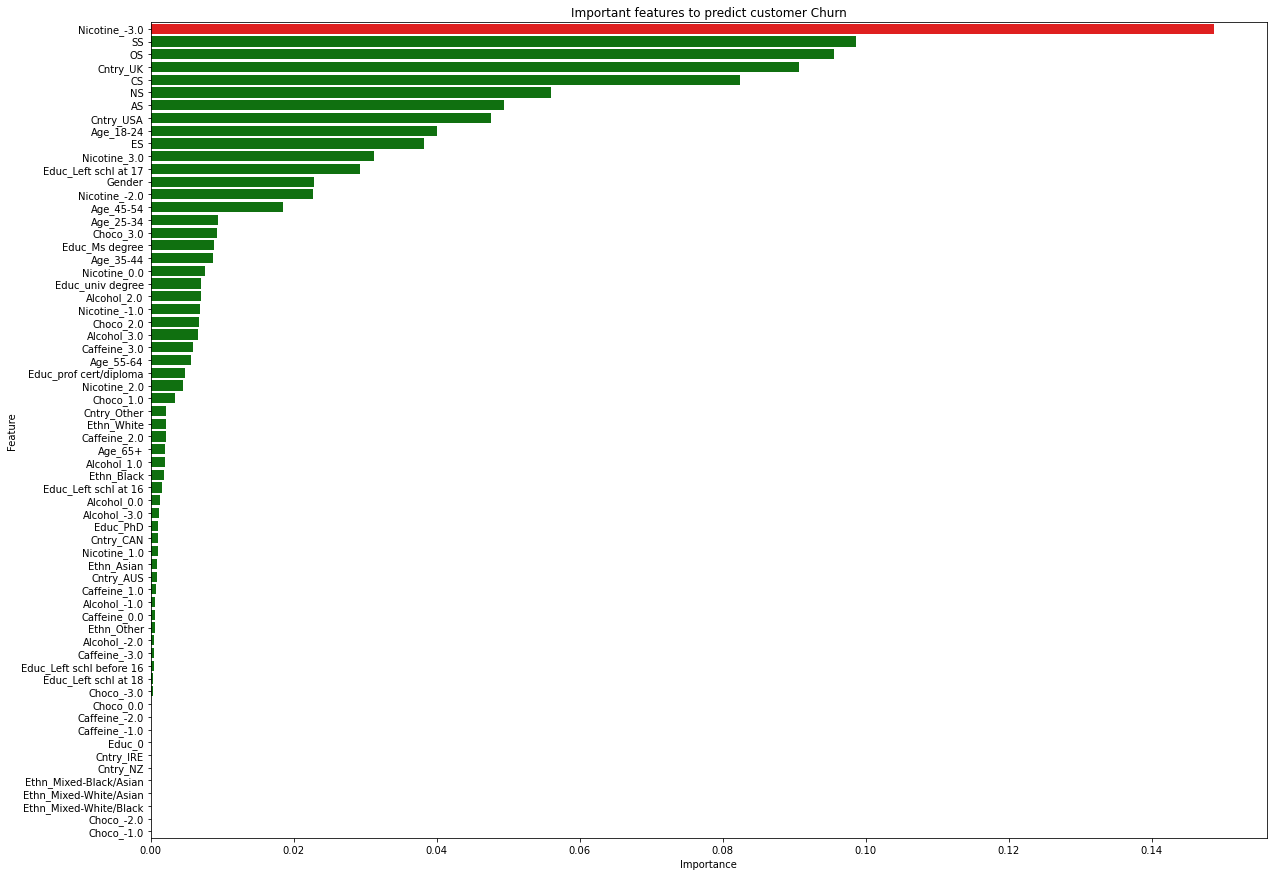

In [30]:
forest_importances_plot(feat_df)

Убираем фичи, которые не сильно влияют на работу модели. 
Все что ниже 47 значения в feat_df

In [31]:
# Разбиваем данные
top_n_features = 46
x_train, x_test, y_train, y_test = train_test_split(train_df[feat_df['Feature'].iloc[:top_n_features].values], y, test_size=.2, random_state=10)

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=False)
    ]


for classifier in classifiers:
    steps = [
        ('clf', classifier),
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(x_train, y_train)   
    print(classifier)
    print('model score: {} \n'.format(roc_auc_score(y_test, pipeline.predict_proba(x_test)[:, 1])))

DecisionTreeClassifier()
model score: 0.7471264367816093 

RandomForestClassifier()
model score: 0.8910225921521997 

GradientBoostingClassifier()
model score: 0.8940943321442727 

LGBMClassifier()
model score: 0.8837891399128023 

model score: 0.8919540229885058 



In [34]:
x_train.shape

(1508, 46)

## **Random Forest**

In [35]:
clf = RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_leaf=5, max_features='sqrt')
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=5)

In [36]:
roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

0.8956401109789932

Точность модели повысилась после удаления менее важных фич по сравнения с деревом, которое обучали для отбора признаков. \
Подбор параметров для RF:

In [37]:
params = {
          'n_estimators': range(31, 255, 16),
          'min_samples_split': [4,5,6],
          'max_depth': [50, 60]
         }

In [38]:
grid_rf = model_grid(RandomForestClassifier(n_jobs=-1), params, x_train, y_train, scoring='roc_auc')

In [39]:
grid_rf.best_params_, grid_rf.best_score_

({'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 111},
 0.9149297728096052)

In [40]:
roc_auc_score(y_test, grid_rf.predict_proba(x_test)[:, 1])

0.8917162108600871

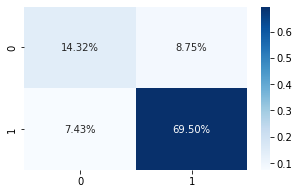

In [41]:
plot_confusion_matrix(y_test, grid_rf.predict(x_test))

## **LightGBM**

In [45]:
params = {
    'max_depth': range(31, 64, 8),
    'learning_rate': np.linspace(0.001, 0.05, 5),
    'n_estimators': range(63, 255, 32),
}

In [46]:
grid_lgbm = model_grid(LGBMClassifier(n_jobs=-1), params, x_train, y_train, scoring='roc_auc')

In [47]:
grid_lgbm.best_params_

{'learning_rate': 0.05, 'max_depth': 31, 'n_estimators': 127}

In [48]:
roc_auc_score(y_test, grid_lgbm.predict_proba(x_test)[:,1])

0.8895362663495838

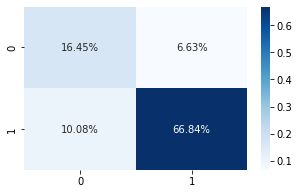

In [49]:
plot_confusion_matrix(y_test, grid_lgbm.predict(x_test))

## **CatBoost**

In [50]:
params = {
    'iterations': range(400, 1300, 400),
    'depth': range(4, 11, 2)
}

In [51]:
grid_cat = model_grid(CatBoostClassifier(verbose=False), params, x_train, y_train, scoring=None )

In [52]:
grid_cat.best_params_, grid_cat.best_score_

({'depth': 4, 'iterations': 800}, 0.8468240522760775)

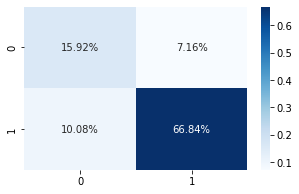

In [53]:
plot_confusion_matrix(y_test, grid_cat.predict(x_test))

## Cross-validation models

In [54]:
# Передаем новые модели с подобранными гиперпараметрами.
# Оцениваем модели в 5ти кратной кросс-валидации, выводим ответы по каждому модели и усредненый результат.

classifiers = [
    RandomForestClassifier(**grid_rf.best_params_),
    LGBMClassifier(**grid_lgbm.best_params_),
    CatBoostClassifier(**grid_cat.best_params_, verbose=False)
    ]

for classifier in classifiers:
    steps = [
        ('clf', classifier),
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(x_train, y_train)
    score_cv = cross_val_score(classifier, x_train, y_train, cv=5, scoring='roc_auc') 
    print(classifier)
    print('model score: %.3f' % pipeline.score(x_test, y_test))
    print('CV: {0}, Mean: {1} \n'.format(score_cv, score_cv.mean()))

RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=111)
model score: 0.822
CV: [0.90230554 0.92070331 0.90731253 0.90789474 0.90994152], Mean: 0.9096315271955699 

LGBMClassifier(learning_rate=0.05, max_depth=31, n_estimators=127)
model score: 0.833
CV: [0.88751747 0.91790871 0.90370284 0.89643275 0.91426901], Mean: 0.9039661543238628 

model score: 0.828
CV: [0.90236376 0.92536097 0.91109688 0.91070175 0.90637427], Mean: 0.9111795269885627 



Как видим по кросс-валидации, что RF и CatBoost имеют выше точность